  
# Keystroke analysis


#### IN791 presentation
#### Sohhom Bandyopadhyay (1551001)

#### Supervised By:   Prof Krishna Prasad Miyapuram

### 27 Nov 2018


### Name typing

#### Task
- Each participant typed their name 20 times
- Backspace and other edits were not allowed

#### Dendrogram from hierarchical clustering of name data
- Hierarchical clustering to reveal the patterns

In [17]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hc
from pyclustering.cluster.xmeans import xmeans
from chunk_utils import *
from sklearn.neighbors.kde import KernelDensity

data_dir = './data/names'
image_dir = './images/'


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# basic init
filenames = list(filter(lambda x: x.endswith('.kdt'), os.listdir(data_dir)))

font = {'size': 16}
matplotlib.rc('font', **font)

In [19]:
with open(data_dir+'//'+filenames[2], 'r') as fh:
    mydata = fh.read()
typedname, rawkd = mydata.split('\n')
tt = typedname.replace(' ','_')
keypairs = list(map(lambda x: x[0]+x[1], zip(tt, tt[1:])))

raw_delays = kdata2delaysOLD(typedname, rawkd)
cumulative_delays = np.array([np.cumsum(delay1) for delay1 in raw_delays.transpose()])

#raw_delays = raw_delays.transpose()
#cumulative_delays = cumulative_delays.transpose()

del1 = np.mean(raw_delays[:10], axis=0)
del2 = np.mean(raw_delays[-10:], axis=0)



len(typedname), typedname, raw_delays.shape, del2.shape, len(keypairs)

(20, 'sohhom bandyopadhyay', (20, 19), (19,), 19)

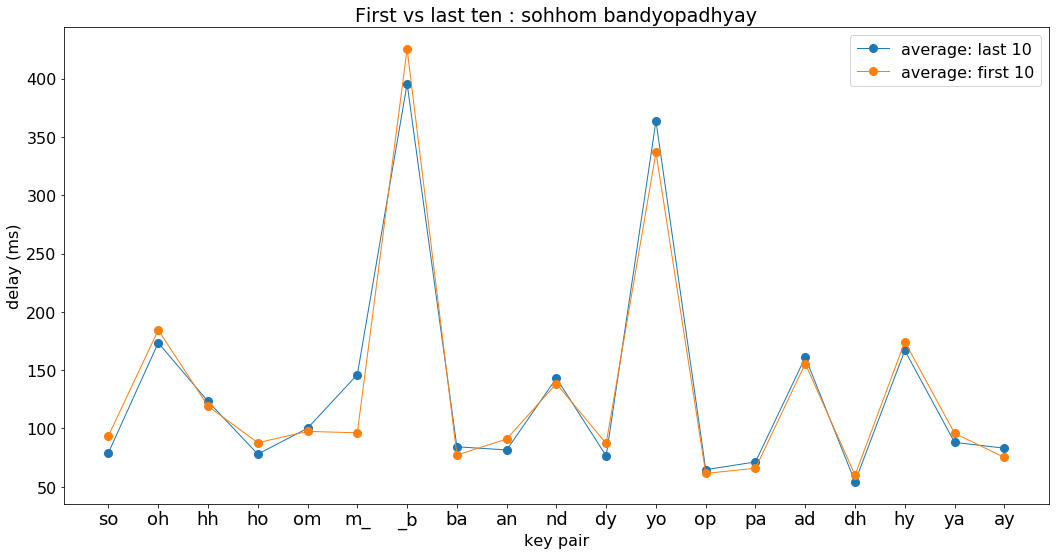

In [20]:
matplotlib.rcParams['figure.figsize'] = 15, 8
_, ax = plt.subplots()
_, __ = ax.set_xticks(range(len(del1))), ax.set_xticklabels(keypairs, fontsize=18)
_, __ = ax.set_ylabel('delay (ms)'), ax.set_xlabel('key pair')
ax.plot(del2, label="average: last 10", lw=1, markersize=8, marker='o')
ax.plot(del1, label="average: first 10", lw=1, markersize=8, marker='o')
plt.legend()
plt.title("First vs last ten : "+typedname)
plt.tight_layout()
plt.savefig('name__first_last_ten.png', format='png')

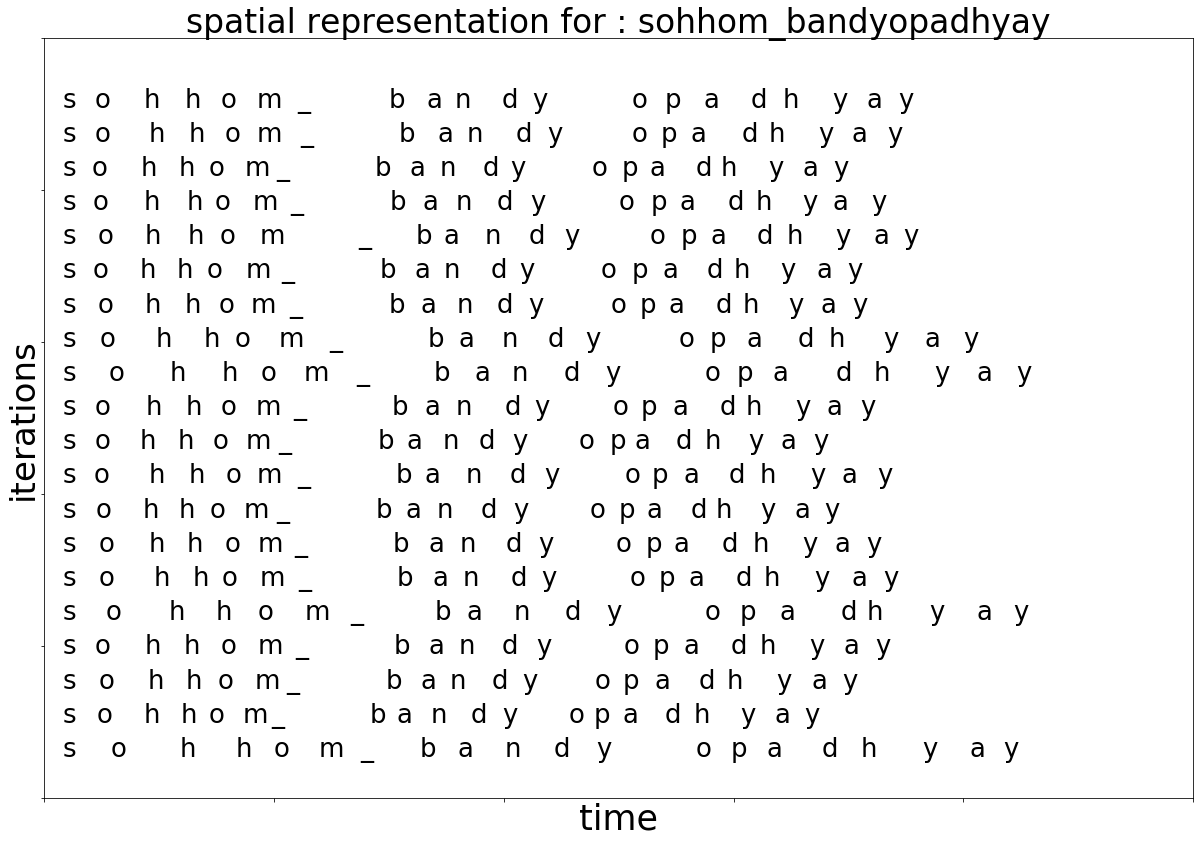

In [21]:
ypos = 0.01
ydelta = 0.045
matplotlib.rcParams['figure.figsize'] = 17,12
typedname_ = typedname.replace(' ','_')
for dd in raw_delays:
    xposvector = get_xpos_from_delays(dd, space_min = 0.016, max_delta_spacing=0.07)
    for char, xpos in zip(typedname_, xposvector):
        plt.text(xpos, ypos + ydelta, char, fontsize=26)
    ypos += ydelta

plt.title('spatial representation for : '+typedname_, fontsize=33)
plt.xlabel('time', fontsize=35)
plt.ylabel('iterations', fontsize=34)
plt.tick_params(axis='both', labelbottom=False, labelleft=False) 
plt.tight_layout()
plt.savefig('name__spatialrep.png', format='png')

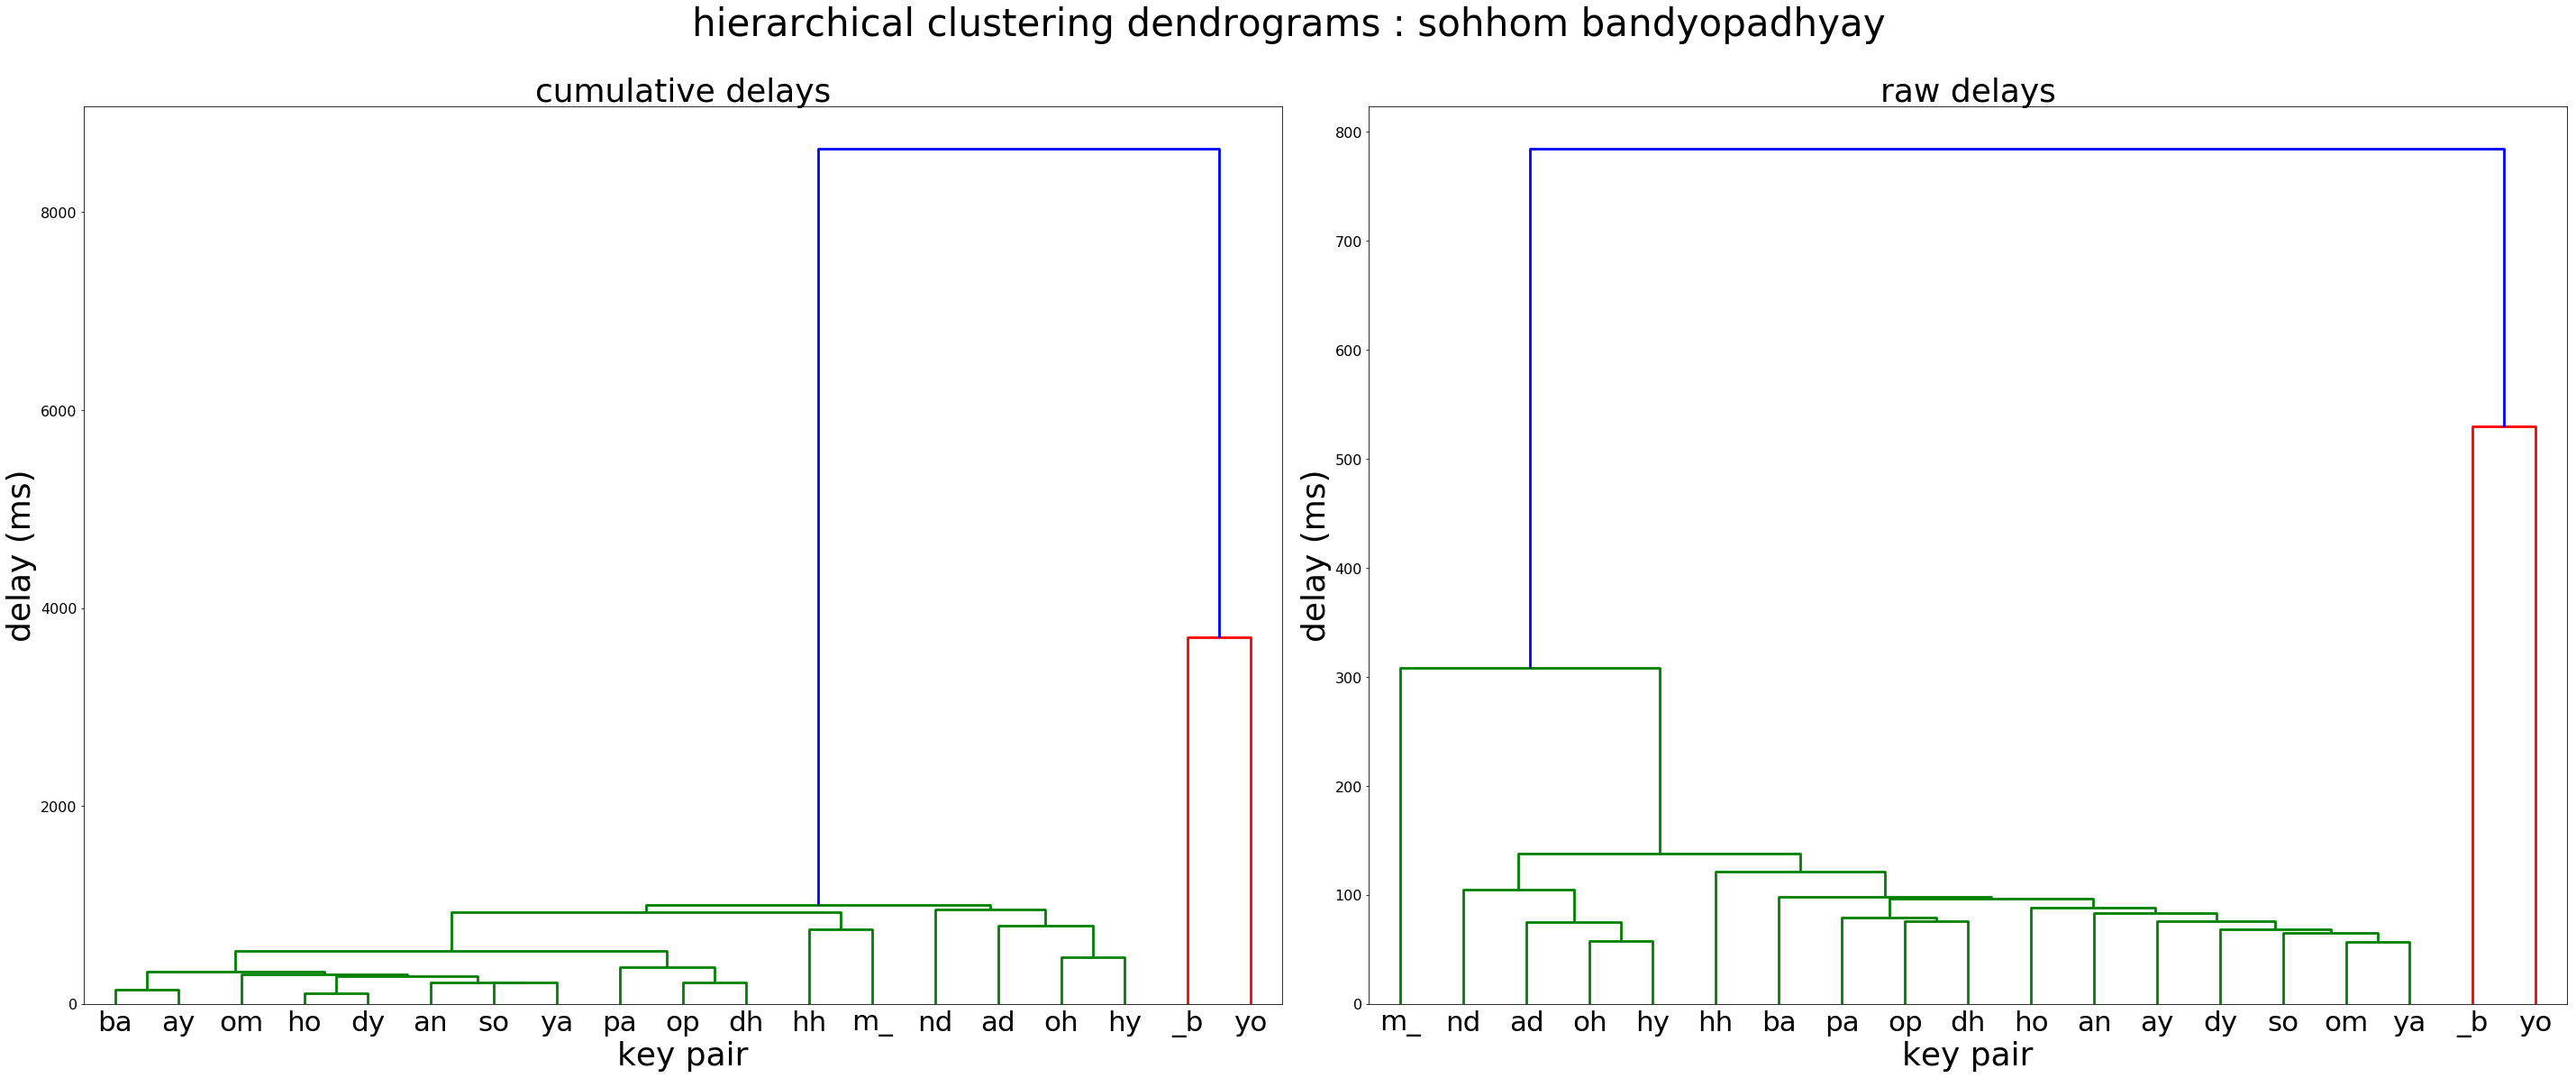

In [22]:
matplotlib.rcParams['figure.figsize'] = 40, 17

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

matplotlib.rcParams['lines.linewidth'] = 2.8

plt.suptitle("hierarchical clustering dendrograms : "+typedname, fontsize=42)

dn = hc.dendrogram(hc.linkage(cumulative_delays,'single'), ax=ax1, labels=keypairs, leaf_font_size=31)
ax1.set_title('cumulative delays', fontsize=36)
ax1.set_ylabel('delay (ms)', fontsize=36)
ax1.set_xlabel('key pair', fontsize=36)

dn = hc.dendrogram(hc.linkage(raw_delays.transpose(),'single'), ax=ax2, labels=keypairs, leaf_font_size=31)
ax2.set_title('raw delays', fontsize=36)
ax2.set_ylabel('delay (ms)', fontsize=36)
ax2.set_xlabel('key pair', fontsize=36)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('name__dendrograms_cumul_raw.png', format='png')

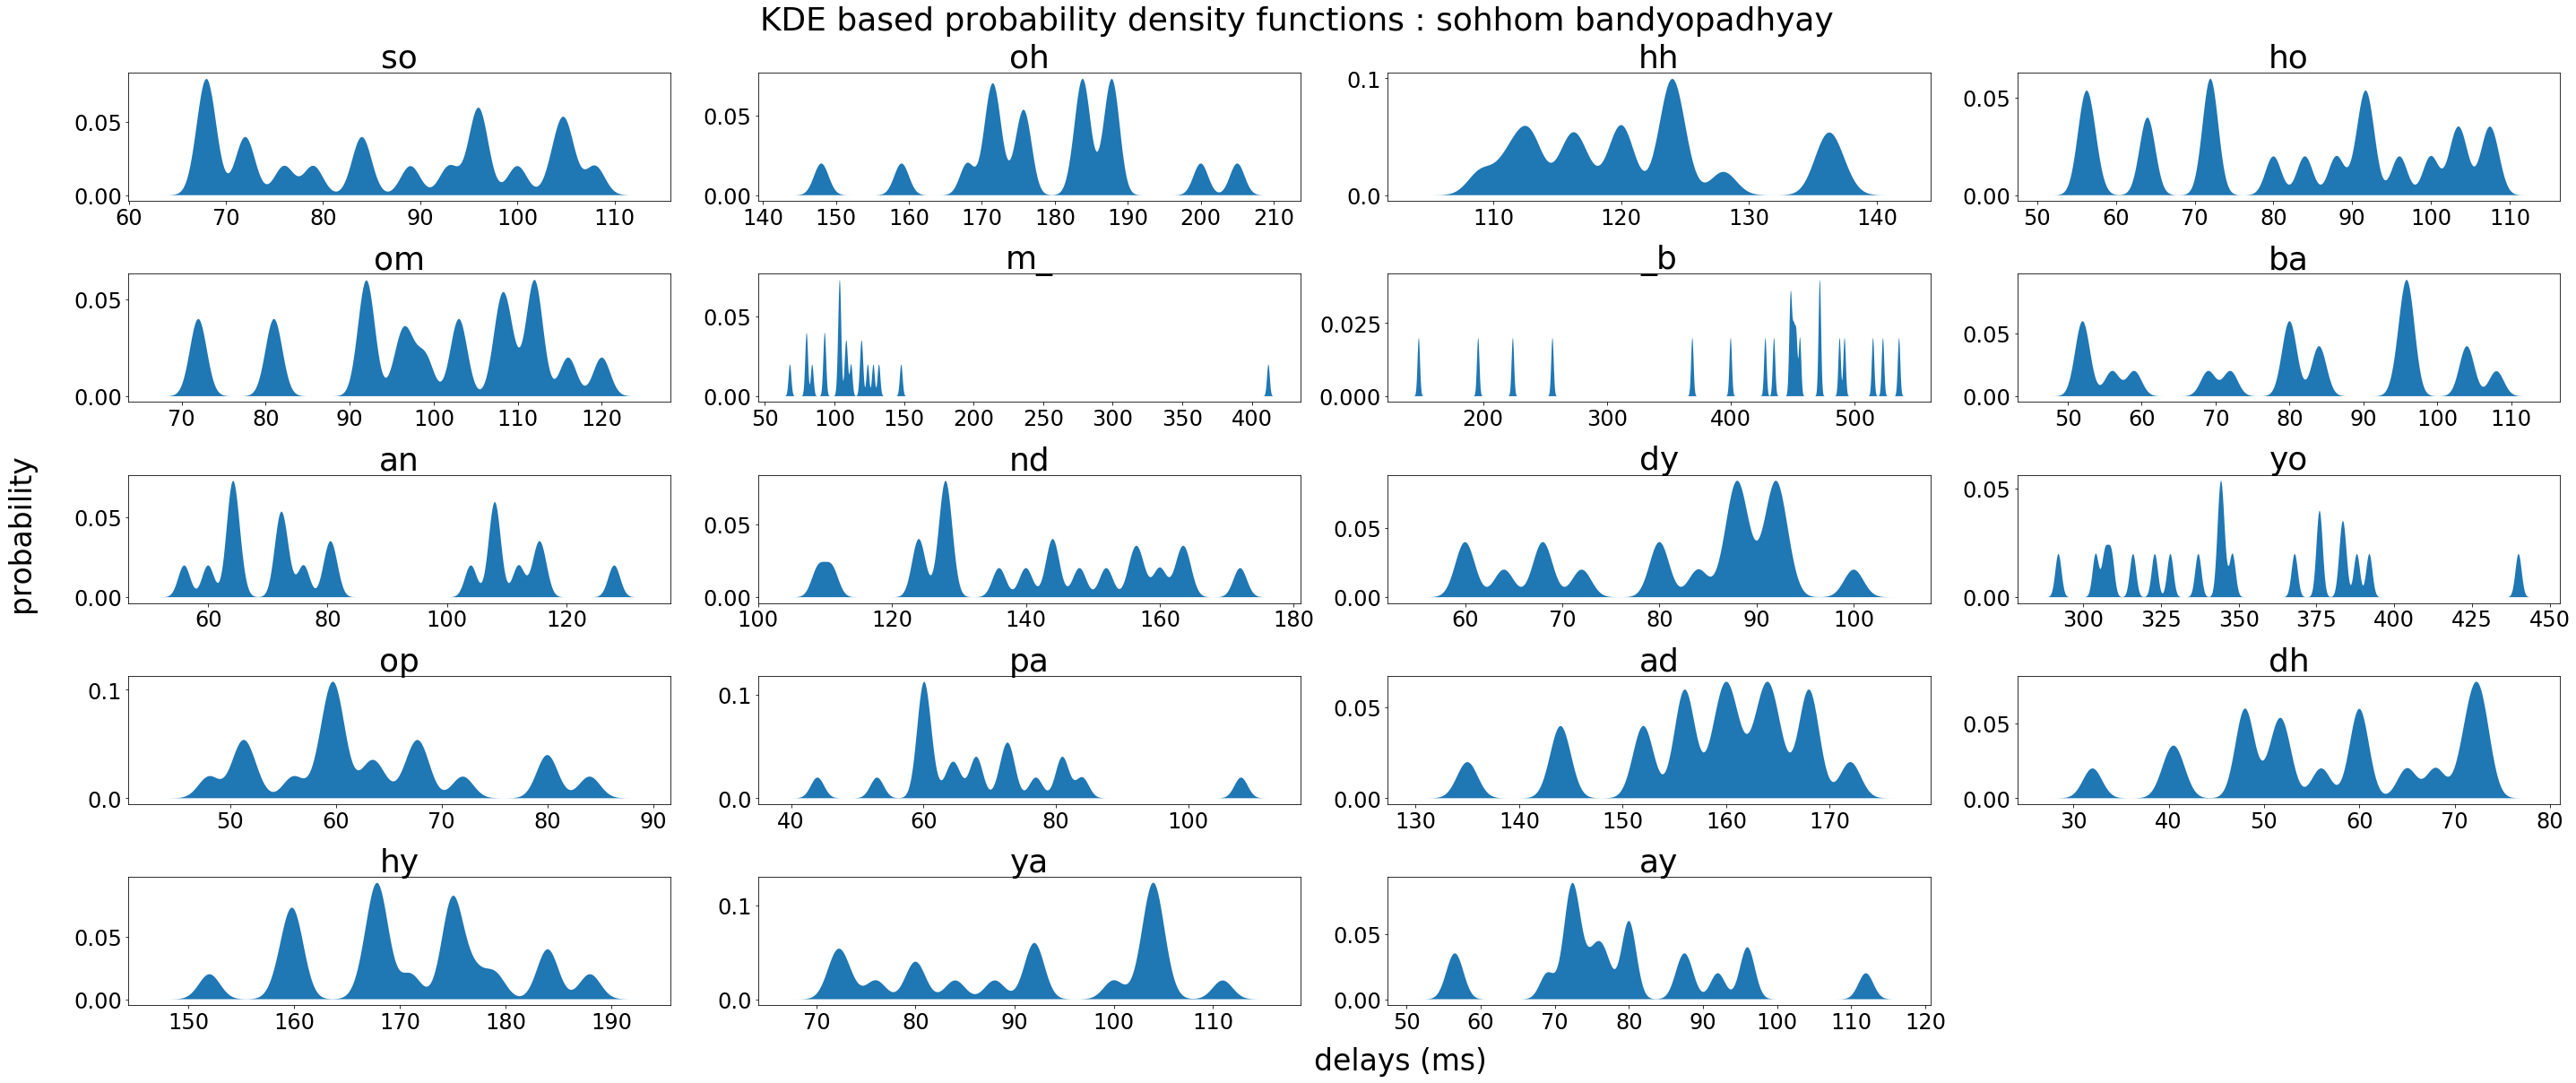

In [32]:
with open(data_dir+'//'+filenames[2], 'r') as fh:
    mydata = fh.read()
typedname, rawkd = mydata.split('\n')
tt = typedname.replace(' ','_')
keypairs = list(map(lambda x: x[0]+x[1], zip(tt, tt[1:])))

raw_delays = kdata2delaysOLD(typedname, rawkd)

models = [KernelDensity() for  x in range(raw_delays.shape[0])]
# for each key in the typed word..build a model
for i in range(raw_delays.shape[1]):
    models[i].fit(raw_delays[:,i].reshape(-1,1))
    
# ===============
    
matplotlib.rcParams['figure.figsize'] = 40,17
fig = plt.figure()
total_plts = len(typedname)-1
n_cols = 4
n_rows = int(np.ceil(total_plts/n_cols)) # want 4 columns, and as many rows as required

for keyIndex in range(len(typedname)-1):
    delayspace = np.linspace(10,1000,7000)
    logprobX = models[keyIndex].score_samples(delayspace.reshape(-1,1))
    prob = np.exp(logprobX)
    epsilon = 1e-8
    nonzero_indx = prob>=epsilon
    prob_nonzero = prob[nonzero_indx]
    delayspace = delayspace[nonzero_indx]
    
    ax1 = fig.add_subplot(n_rows,n_cols,keyIndex+1)
    ax1.fill(delayspace,prob_nonzero)
    ax1.set_title(keypairs[keyIndex], fontsize=36)
    ax1.tick_params(axis='both', which='major', labelsize=24)
    
    
plt.subplots_adjust(wspace=0.2, hspace=0.8)
fig.text(0.54, 0.01, 'delays (ms)', ha='center', fontsize=33)
fig.text(0, 0.5, 'probability', va='center', rotation='vertical', fontsize=33)
plt.suptitle("KDE based probability density functions : {}".format(typedname),fontsize=36)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.96])
plt.savefig('name__kde_subplots.png',format='png')
plt.show()

In [31]:
filenames

['recorded_nithin_george.kdt',
 'recorded_Vaishnavi_Sunil_Patil.kdt',
 'recorded_sohhom_bandyopadhyay.kdt',
 'recorded_curb_your_enthusiasm.kdt',
 'recorded_Bharatesh_Shiraguppi.kdt',
 'recorded_Lakshman_Chakrav.kdt',
 'recorded_dyutiman_mukhopadhyay.kdt',
 'recorded_unnati palan.kdt',
 'recorded_SHRUTI_GOYAL.kdt',
 'recorded_after_careful_consideration.kdt',
 'recorded_Sreekanth_C.kdt',
 'recorded_jagini kishore kumar.kdt',
 'recorded_Megha_Sanyal.kdt',
 'recorded_Archit_Sunat.kdt',
 'recorded_Pranjali Shrikant Kulkarni.kdt',
 'recorded_keystroke_dynamics.kdt',
 'recorded_Vishav_Jyoti.kdt',
 'recorded_ashish_joseph.kdt',
 'recorded_Rachit_Chhaya.kdt',
 'recorded_manasi_wali.kdt',
 'recorded_somdotta_mukherjee.kdt',
 'recorded_Taronish_Pastakia.kdt',
 'recorded_jyoti_bandyopadhyay.kdt',
 'recorded_Goldy_Yadav.kdt',
 'recorded_krishna_prasad_miyapuram.kdt',
 'recorded_narmadha_nagaraj.kdt',
 'recorded_midhula_chandran.kdt',
 'recorded_Khobragade_Prateek.kdt',
 'recorded_jitesh_shaw.kdt'